# CODE FOR THE QUESTIONS ASKED

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('../data/email_table.csv')
data.head(5)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened_id,clicked_id
0,85120,short_email,personalized,2,Sunday,US,5,284534.0,609056.0
1,966622,long_email,personalized,12,Sunday,UK,2,609056.0,870980.0
2,777221,long_email,personalized,11,Wednesday,US,2,220820.0,935124.0
3,493711,short_email,generic,6,Monday,UK,1,905936.0,158501.0
4,106887,long_email,generic,14,Monday,US,6,164034.0,177561.0


In [3]:
# Checking if there are any duplicates in the 'email_id' column
duplicate_emails = data[data.duplicated( keep=False)]

print(duplicate_emails)

Empty DataFrame
Columns: [email_id, email_text, email_version, hour, weekday, user_country, user_past_purchases, opened_id, clicked_id]
Index: []


### Percentage of users opened the email and percentage clicked on the link

In [4]:
# Total number of users
total_users = len(data)

# Number of users who opened the email
num_opened = data['opened_id'].notna().sum()

# Number of users who clicked the link
num_clicked = data['clicked_id'].notna().sum()

# Calculate percentages
opened_percentage = (num_opened / total_users) * 100
clicked_percentage = (num_clicked / total_users) * 100

# Display the results
print(f"Percentage of users who opened the email: {opened_percentage:.2f}%")
print(f"Percentage of users who clicked the link: {clicked_percentage:.2f}%")


Percentage of users who opened the email: 10.35%
Percentage of users who clicked the link: 2.12%


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [6]:
# Load data
data = pd.read_csv('../data/email_table.csv')

# 1. Prepare target variable: whether the user clicked or not
data['clicked'] = data['clicked_id'].notna().astype(int)

# 2. Select features for modeling
features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

X = data[features]
y = data[target]

# Preprocessing
categorical_features = ['email_text', 'email_version', 'weekday', 'user_country']
numeric_features = ['hour', 'user_past_purchases']

# Column transformer: OneHotEncode categorical & scale numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# 3. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 5. Pipeline: Preprocessing + Model
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(class_weight = 'balanced', random_state=42))
])
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10,20],
    'model__min_samples_split': [2,5],
    'model__min_samples_leaf': [1, 2]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1',n_jobs = -1, verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:\n", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters:
 {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [8]:
# Best model
best_model = grid_search.best_estimator_


# 7. Evaluate the model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91     19587
           1       0.02      0.13      0.03       413

    accuracy                           0.84     20000
   macro avg       0.50      0.49      0.47     20000
weighted avg       0.96      0.84      0.90     20000

Confusion Matrix:
 [[16781  2806]
 [  360    53]]
ROC AUC Score: 0.4819


### Finding the importance of the features which can generate more number of clicks.

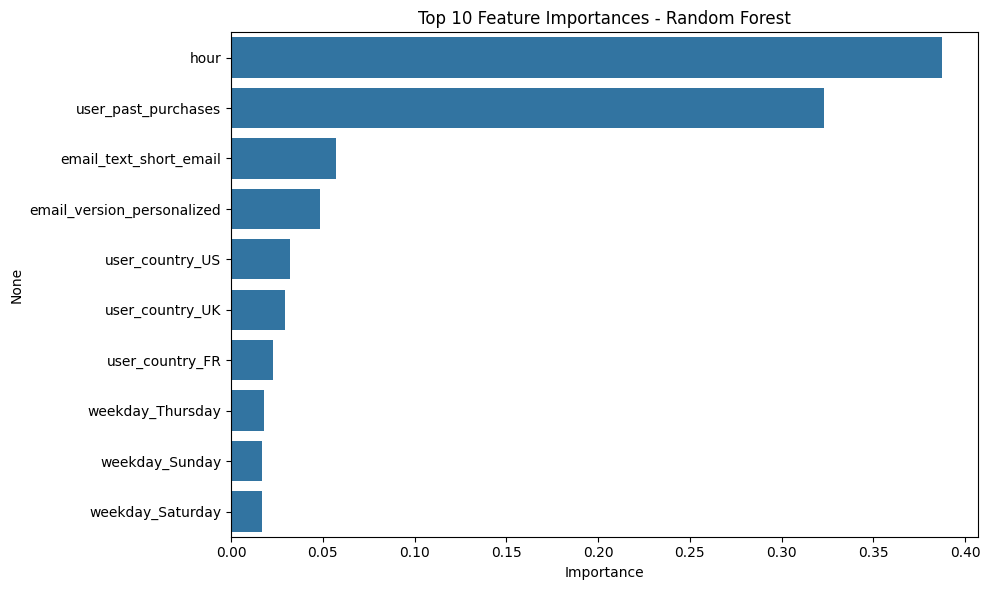

In [15]:
# Get feature names from preprocessing
feature_importance = best_model.named_steps['preprocessing'].named_transformers_['cat']
feature_names = (
    feature_importance.get_feature_names_out(categorical_features).tolist() +
    numeric_features
)

# Get feature importances
importances = best_model.named_steps['model'].feature_importances_
# Plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


#### Visualizing the two important features

C:\Users\Praneeth Kumar\AppData\Local\Temp\ipykernel_23044\611217526.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  click_by_purchases = data.groupby('purchases_bin').agg(click_rate=('clicked','mean'),count=('clicked', 'count')).reset_index()
C:\Users\Praneeth Kumar\AppData\Local\Temp\ipykernel_23044\611217526.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=click_by_purchases, x='purchases_bin', y='click_rate',palette= 'Purples_d')


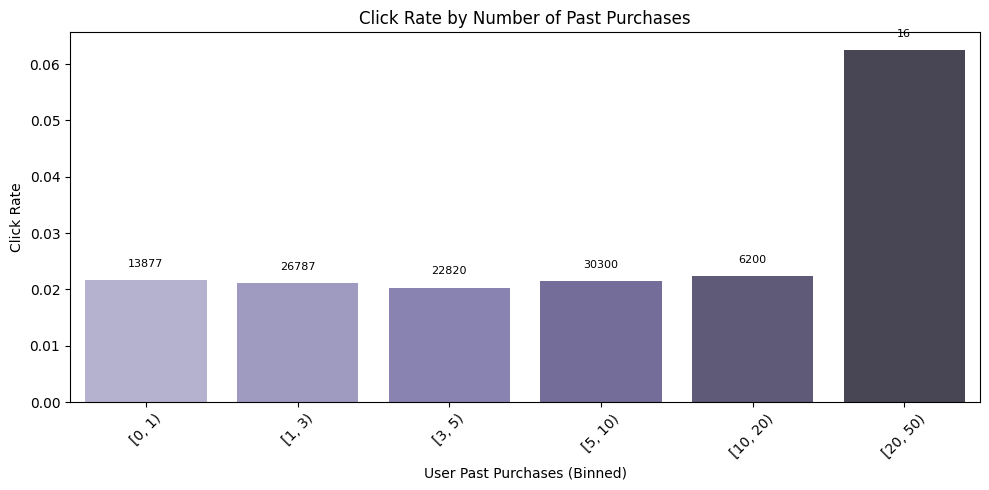

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# 2. Click Rate by User Past Purchases (binned for clarity)
data['purchases_bin'] = pd.cut(data['user_past_purchases'], bins=[0, 1, 3, 5, 10, 20, 50], right=False)
click_by_purchases = data.groupby('purchases_bin').agg(click_rate=('clicked','mean'),count=('clicked', 'count')).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=click_by_purchases, x='purchases_bin', y='click_rate',palette= 'Purples_d')
plt.title('Click Rate by Number of Past Purchases')
plt.xlabel('User Past Purchases (Binned)')
plt.ylabel('Click Rate')
plt.xticks(rotation=45)

# Add counts on top of bars
for index, row in click_by_purchases.iterrows():
    plt.text(index, row.click_rate + 0.002, f"{row['count']}", ha='center', va='bottom', fontsize=8)


plt.tight_layout()
plt.show()


C:\Users\Praneeth Kumar\AppData\Local\Temp\ipykernel_23044\444382425.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=click_by_hour, x='hour', y='click_rate', palette='Blues_d')


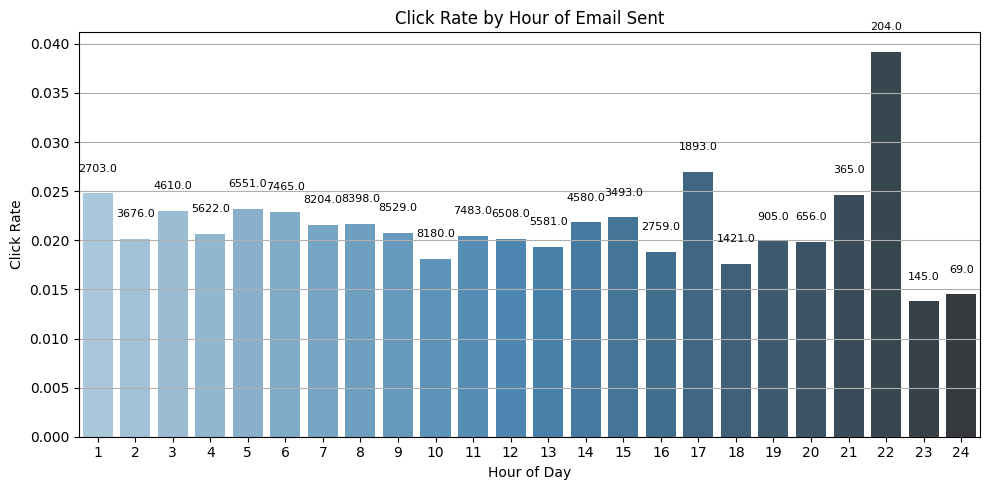

In [ ]:
# Ensure clicked_id is binary (0 or 1)
data['clicked'] = data['clicked_id'].notna().astype(int)

# 1. Click Rate by Hour
click_by_hour = data.groupby('hour').agg(click_rate=('clicked', 'mean'),count=('clicked', 'count')).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=click_by_hour, x='hour', y='click_rate', palette='Blues_d')
plt.title('Click Rate by Hour of Email Sent')
plt.xlabel('Hour of Day')
plt.ylabel('Click Rate')
plt.grid(axis = 'y')

# Add counts on top of bars
for index, row in click_by_hour.iterrows():
    plt.text(row.name, row.click_rate + 0.002, f"{row['count']}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Making sure that targeting the both features above gonna yield a good improvement

Baseline CTR (all users): 0.0212
Model-based CTR (top 10%): 0.0841
Estimated Improvement: 296.80%


C:\Users\Praneeth Kumar\AppData\Local\Temp\ipykernel_23044\2792138661.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


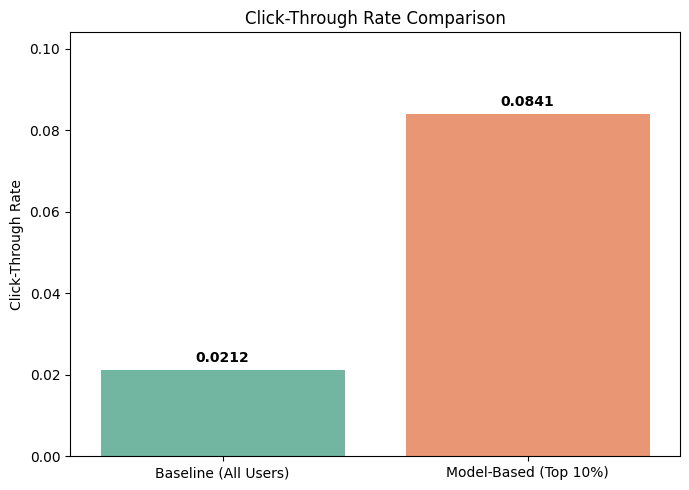

In [12]:
# Recreate the features and target
features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

# Add clicked column if not already
data['clicked'] = data['clicked_id'].notna().astype(int)

X = data[features]
y = data[target]

# 1. Use the trained pipeline (best_model from GridSearchCV) to predict probabilities
probas = best_model.predict_proba(X)[:, 1]  # Probabilities of class 1 (click)
data['predicted_proba'] = probas

# 2. Compute baseline CTR (sending to everyone)
baseline_ctr = data['clicked'].mean()

# 3. Simulate model-based email sending: top 20% most likely to click
top_percent = 0.1  # Try 10%, 20%, etc.
threshold = data['predicted_proba'].quantile(1 - top_percent)
top_data = data[data['predicted_proba'] >= threshold]

model_ctr = top_data['clicked'].mean()

# 4. Print results
print(f"Baseline CTR (all users): {baseline_ctr:.4f}")
print(f"Model-based CTR (top {int(top_percent * 100)}%): {model_ctr:.4f}")
print(f"Estimated Improvement: {((model_ctr - baseline_ctr) / baseline_ctr) * 100:.2f}%")

# 5. Optional: Plot the result
plt.figure(figsize=(7, 5))
sns.barplot(
    x=['Baseline (All Users)', f'Model-Based (Top {int(top_percent*100)}%)'],
    y=[baseline_ctr, model_ctr],
    palette='Set2'
)
plt.title('Click-Through Rate Comparison')
plt.ylabel('Click-Through Rate')
plt.ylim(0, max(baseline_ctr, model_ctr) + 0.02)

# Add value labels
for i, rate in enumerate([baseline_ctr, model_ctr]):
    plt.text(i, rate + 0.002, f"{rate:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
